<a href="https://colab.research.google.com/github/ArmandDS/jobs_recommendations/blob/master/job_analysis_content_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect to gdrive to get the datasets

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!ls -ls /content/gdrive/'My Drive'/recommenderData

total 57170
 3711 -rw------- 1 root root  3799274 Jun 21 02:45 datasetJuguetes.csv
52892 -rw------- 1 root root 54160654 Jun 22 23:56 job-recommendation-datasets.zip
  568 -rw------- 1 root root   580698 Jun 21 02:42 ValoracionesUsuarios.csv


In [3]:
!unzip   /content/gdrive/'My Drive'/recommenderData/job-recommendation-datasets.zip

Archive:  /content/gdrive/My Drive/recommenderData/job-recommendation-datasets.zip
  inflating: Positions_Of_Interest.csv  
  inflating: job_data.csv            
  inflating: Job_Views.csv           
  inflating: Experience.csv          
  inflating: Combined_Jobs_Final.csv  


## Importing libraries

In [0]:
import pandas as pd
import numpy as np
import nltk


## Load the data

Loading the jobs dataset

In [5]:

df_jobs = pd.read_csv("Combined_Jobs_Final.csv")
df_jobs.head()

,Job.ID,Provider,Status,Slug,Title,Position,Company,City,State.Name,State.Code,Address,Latitude,Longitude,Industry,Job.Description,Requirements,Salary,Listing.Start,Listing.End,Employment.Type,Education.Required,Created.At,Updated.At
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,NaN,37.443346,-122.161170,Food and Beverages,Tacolicious' first Palo Alto store just opened...,NaN,8.00,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,NaN,37.789830,-122.404268,Food and Beverages,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN,0.00,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC
2,117,1,open,san-francisco-ca-machka-restaurants-corp-barte...,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,California,CA,NaN,37.795597,-122.402963,Food and Beverages,We are a popular Mediterranean wine bar and re...,NaN,11.00,NaN,NaN,Part-Time,NaN,2013-07-16 09:34:10 UTC,2014-08-16 15:35:37 UTC
3,121,1,open,brisbane-ca-teriyaki-house-server,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,California,CA,NaN,37.685073,-122.400275,Food and Beverages,● Serve food/drinks to customers in a profess...,NaN,10.55,NaN,NaN,Part-Time,NaN,2013-09-04 15:40:30 UTC,2014-08-16 15:35:38 UTC
4,127,1,open,los-angeles-ca-rosa-mexicano-sunset-kitchen-st...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,California,CA,NaN,34.073384,-118.460439,Food and Beverages,"Located at the heart of Hollywood, we are one ...",NaN,10.55,NaN,NaN,Part-Time,NaN,2013-07-17 15:26:18 UTC,2014-08-16 15:35:40 UTC


In [6]:
df_jobs.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84090 entries, 0 to 84089
Data columns (total 23 columns):
Job.ID                84090 non-null int64
Provider              84090 non-null int64
Status                84090 non-null object
Slug                  84090 non-null object
Title                 84090 non-null object
Position              84090 non-null object
Company               81819 non-null object
City                  83955 non-null object
State.Name            83919 non-null object
State.Code            83919 non-null object
Address               36 non-null object
Latitude              84090 non-null float64
Longitude             84090 non-null float64
Industry              267 non-null object
Job.Description       84034 non-null object
Requirements          0 non-null float64
Salary                229 non-null float64
Listing.Start         83407 non-null object
Listing.End           83923 non-null object
Employment.Type       84080 non-null object
Education.Required  

## Exploratory Data Analysis

#### First check the NA's

In [7]:
df_jobs.isnull().sum()

Job.ID                    0
Provider                  0
Status                    0
Slug                      0
Title                     0
Position                  0
Company                2271
City                    135
State.Name              171
State.Code              171
Address               84054
Latitude                  0
Longitude                 0
Industry              83823
Job.Description          56
Requirements          84090
Salary                83861
Listing.Start           683
Listing.End             167
Employment.Type          10
Education.Required      267
Created.At                0
Updated.At                0
dtype: int64

 From the above list we see that there are lot of NaN values, perform data clean
 ing for each and every column

#### Selecting the columns for the jobs corpus


For this example we only consider the columns: 'Job.ID', 'Title', 'Position', 'Company','City', 'Empl_type','Edu_req','Job_Description'

In [8]:

cols = ['Job.ID']+['Title']+['Position']+ ['Company']+['City']+['Employment.Type']+['Job.Description']
df_jobs =df_jobs[cols]
df_jobs.columns = ['Job.ID', 'Title', 'Position', 'Company','City', 'Empl_type','Job_Description']
df_jobs.head() 

,Job.ID,Title,Position,Company,City,Empl_type,Job_Description
0,111,Server @ Tacolicious,Server,Tacolicious,Palo Alto,Part-Time,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...
2,117,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,Part-Time,We are a popular Mediterranean wine bar and re...
3,121,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,Part-Time,● Serve food/drinks to customers in a profess...
4,127,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,Part-Time,"Located at the heart of Hollywood, we are one ..."


In [9]:
# checking for the null values again.
df_jobs.isnull().sum()

Job.ID                0
Title                 0
Position              0
Company            2271
City                135
Empl_type            10
Job_Description      56
dtype: int64

#### Let´s check the NA's by plotting them

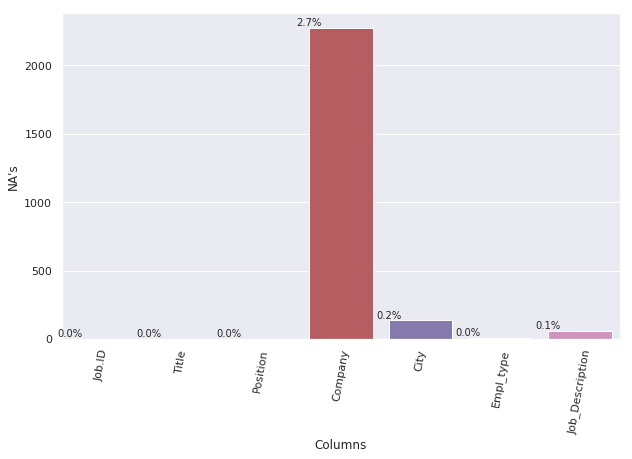

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
x = df_jobs.columns
y = df_jobs.isnull().sum()
plt.figure(figsize=(10,6))
sns.set()
sns.barplot(x,y)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(),
            height + 2,
            str(100*round(int(height)/df_jobs.shape[0], 3)) +"%",
            fontsize=10, ha='center', va='bottom')
ax.set_xlabel("Columns")
ax.set_ylabel("NA's")
plt.xticks(rotation=80)

plt.show()

selecting NaN rows of city

In [11]:

df_nan_city = df_jobs[pd.isnull(df_jobs['City'])]
print(df_nan_city.shape)
df_nan_city.head()

(135, 7)


,Job.ID,Title,Position,Company,City,Empl_type,Job_Description
3425,142044,Registered Nurse (RN) @ St. Francis Hospital,Registered Nurse (RN),St. Francis Hospital,NaN,Full-Time/Part-Time,Under the direction of the Clinical Coordinato...
3433,142054,Sales Representative - Business Development Op...,Sales Representative - Business Development Op...,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3434,142055,New Business Executive @ CHI Payment Systems,New Business Executive,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3435,142056,Outside Sales Representative (Business Develop...,Outside Sales Representative (Business Develop...,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3436,142057,Outside Sales Representative @ CHI Payment Sys...,Outside Sales Representative,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."


In [12]:
df_nan_city.groupby(['Company'])['City'].count() 

Company
Academic Year In America                0
CBS Healthcare Services and Staffing    0
CHI Payment Systems                     0
Driveline Retail                        0
Educational Testing Services            0
Genesis Health System                   0
Genesis Health Systems                  0
Home Instead Senior Care                0
St. Francis Hospital                    0
Volvo Group                             0
Name: City, dtype: int64

#### We see that there are only 9 companies cities that are having NaN values so it must be manually adding their head quarters (by simply searching at google)


In [0]:
#replacing nan with thier headquarters location
df_jobs['Company'] = df_jobs['Company'].replace(['Genesis Health Systems'], 'Genesis Health System')
df_jobs.loc[df_jobs.Company == 'CHI Payment Systems', 'City'] = 'Illinois'
df_jobs.loc[df_jobs.Company == 'Academic Year In America', 'City'] = 'Stamford'
df_jobs.loc[df_jobs.Company == 'CBS Healthcare Services and Staffing ', 'City'] = 'Urbandale'
df_jobs.loc[df_jobs.Company == 'Driveline Retail', 'City'] = 'Coppell'
df_jobs.loc[df_jobs.Company == 'Educational Testing Services', 'City'] = 'New Jersey'
df_jobs.loc[df_jobs.Company == 'Genesis Health System', 'City'] = 'Davennport'
df_jobs.loc[df_jobs.Company == 'Home Instead Senior Care', 'City'] = 'Nebraska'
df_jobs.loc[df_jobs.Company == 'St. Francis Hospital', 'City'] = 'New York'
df_jobs.loc[df_jobs.Company == 'Volvo Group', 'City'] = 'Washington'
df_jobs.loc[df_jobs.Company == 'CBS Healthcare Services and Staffing', 'City'] = 'Urbandale'

In [14]:
df_jobs.isnull().sum()

Job.ID                0
Title                 0
Position              0
Company            2271
City                  0
Empl_type            10
Job_Description      56
dtype: int64

In [15]:
#The employement type NA are from Uber so I assume as part-time and full time
df_nan_emp = df_jobs[pd.isnull(df_jobs['Empl_type'])]
df_nan_emp.head()


,Job.ID,Title,Position,Company,City,Empl_type,Job_Description
10768,153197,Driving Partner @ Uber,Driving Partner,Uber,San Francisco,NaN,Uber is changing the way the world moves. From...
10769,153198,Driving Partner @ Uber,Driving Partner,Uber,Los Angeles,NaN,Uber is changing the way the world moves. From...
10770,153199,Driving Partner @ Uber,Driving Partner,Uber,Chicago,NaN,Uber is changing the way the world moves. From...
10771,153200,Driving Partner @ Uber,Driving Partner,Uber,Boston,NaN,Uber is changing the way the world moves. From...
10772,153201,Driving Partner @ Uber,Driving Partner,Uber,Ann Arbor,NaN,Uber is changing the way the world moves. From...


In [16]:
df_jobs['Empl_type'].unique()

array(['Part-Time', 'Full-Time/Part-Time', 'Seasonal/Temp', 'Per Diem',
       'Intern', nan, 'Full-Time', 'Contract', 'Temporary/seasonal'],
      dtype=object)

In [17]:
#replacing na values with part time/full time
df_jobs['Empl_type']=df_jobs['Empl_type'].fillna('Full-Time/Part-Time')
df_jobs.groupby(['Empl_type'])['Company'].count()
df_jobs.head()

,Job.ID,Title,Position,Company,City,Empl_type,Job_Description
0,111,Server @ Tacolicious,Server,Tacolicious,Palo Alto,Part-Time,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...
2,117,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,Part-Time,We are a popular Mediterranean wine bar and re...
3,121,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,Part-Time,● Serve food/drinks to customers in a profess...
4,127,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,Part-Time,"Located at the heart of Hollywood, we are one ..."


##  Creating the jobs corpus 

#### combining the columns of position, company, city, emp_type and position

In [18]:
df_jobs["text"] = df_jobs["Position"].map(str) + " " + df_jobs["Company"] +" "+ df_jobs["City"]+ " "+df_jobs['Empl_type']+" "+df_jobs['Job_Description'] +" "+df_jobs['Title']
df_jobs.head(2)

,Job.ID,Title,Position,Company,City,Empl_type,Job_Description,text
0,111,Server @ Tacolicious,Server,Tacolicious,Palo Alto,Part-Time,Tacolicious' first Palo Alto store just opened...,Server Tacolicious Palo Alto Part-Time Tacolic...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...,Kitchen Staff/Chef Claude Lane San Francisco P...


In [19]:
df_all = df_jobs[['Job.ID', 'text', 'Title']]

df_all = df_all.fillna(" ")

df_all.head()

,Job.ID,text,Title
0,111,Server Tacolicious Palo Alto Part-Time Tacolic...,Server @ Tacolicious
1,113,Kitchen Staff/Chef Claude Lane San Francisco P...,Kitchen Staff/Chef @ Claude Lane
2,117,Bartender Machka Restaurants Corp. San Francis...,Bartender @ Machka Restaurants Corp.
3,121,Server Teriyaki House Brisbane Part-Time ● Se...,Server @ Teriyaki House
4,127,Kitchen Staff/Chef Rosa Mexicano - Sunset Los ...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset


In [20]:
df_all.shape

(84090, 3)

In [21]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:

from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2   
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text=re.sub("(\\d|\\W)+"," ",text) 
  text = text.replace("nbsp", "")
  clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
  clean_text2 = [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)


#### Cleaning the jobs corpus 

In [0]:
df_all['text'] = df_all['text'].apply(clean_txt)

#### Finally we ended we a clean text for the jobs dataset:

In [24]:
df_all.head()

,Job.ID,text,Title
0,111,server tacolicious palo alto part time tacolic...,Server @ Tacolicious
1,113,kitchen staff chef claude lane san francisco p...,Kitchen Staff/Chef @ Claude Lane
2,117,bartender machka restaurants corp san francisc...,Bartender @ Machka Restaurants Corp.
3,121,server teriyaki house brisbane part time serve...,Server @ Teriyaki House
4,127,kitchen staff chef rosa mexicano sunset los an...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset


####TF-IDF ( Term Frequency - Inverse Document Frequency ) 


In [25]:

#initializing tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

tfidf_jobid = tfidf_vectorizer.fit_transform((df_all['text'])) #fitting and transforming the vector
tfidf_jobid

<84090x50754 sparse matrix of type '<class 'numpy.float64'>'
	with 8263698 stored elements in Compressed Sparse Row format>

# Cretating the User Corpus
Let's Take the dataset called job views.

In [26]:
df_job_view = pd.read_csv("Job_Views.csv")
df_job_view.head(2)


,Applicant.ID,Job.ID,Title,Position,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At
0,10000,73666,Cashiers & Valets Needed! @ WallyPark,Cashiers & Valets Needed!,WallyPark,Newark,New Jersey,NJ,NaN,2014-12-12 20:12:35 UTC,2014-12-12 20:31:24 UTC,1129.0,2014-12-12 20:12:35 UTC,2014-12-12 20:12:35 UTC
1,10000,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City,New York,NY,NaN,2014-12-12 20:08:50 UTC,2014-12-12 20:10:15 UTC,84.0,2014-12-12 20:08:50 UTC,2014-12-12 20:08:50 UTC


In this case we will use only the columns 'Applicant.ID', 'Job.ID', 'Position', 'Company','City'

In [27]:

df_job_view = df_job_view[['Applicant.ID', 'Job.ID', 'Position', 'Company','City']]
df_job_view["select_pos_com_city"] = df_job_view["Position"].map(str) + "  " + df_job_view["Company"] +"  "+ df_job_view["City"]
df_job_view['select_pos_com_city'] = df_job_view['select_pos_com_city'].map(str).apply(clean_txt)
df_job_view['select_pos_com_city'] = df_job_view['select_pos_com_city'].str.lower()
df_job_view = df_job_view[['Applicant.ID','select_pos_com_city']]
df_job_view.head()


,Applicant.ID,select_pos_com_city
0,10000,cashier valet need wallypark newark
1,10000,macys seasonal retail fragrance cashier garden...
2,10001,part time showroom sales cashier grizzly indus...
3,10002,event specialist part time advantage sales mar...
4,10002,bonefish kitchen staff bonefish grill greenville


### Experience Dataset


In [28]:
#Experience
df_experience = pd.read_csv("Experience.csv")
df_experience.head(2)

,Applicant.ID,Position.Name,Employer.Name,City,State.Name,State.Code,Start.Date,End.Date,Job.Description,Salary,Can.Contact.Employer,Created.At,Updated.At
0,10001,Account Manager / Sales Administration / Quali...,Barcode Resourcing,Bellingham,Washington,WA,2012-10-15,NaN,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
1,10001,Electronics Technician / Item Master Controller,Ryzex Group,Bellingham,Washington,WA,2001-12-01,2012-04-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC


In [29]:
#taking only Position
df_experience= df_experience[['Applicant.ID','Position.Name']]
#cleaning the text
df_experience['Position.Name'] = df_experience['Position.Name'].map(str).apply(clean_txt)
df_experience.head()


,Applicant.ID,Position.Name
0,10001,account manager sales administration quality a...
1,10001,electronics technician item master controller
2,10001,machine operator
3,10003,maintenance technician
4,10003,electrical helper


In [30]:
df_experience =  df_experience.sort_values(by='Applicant.ID')
df_experience = df_experience.fillna(" ")
df_experience.head()


,Applicant.ID,Position.Name
2763,2,volunteer
2762,2,writer uloop blog
3759,3,market intern
3758,3,server
3757,3,prep cook


same applicant has 3 applications 100001 in sigle line so we need to join them

In [31]:
#adding same rows to a single row
df_experience = df_experience.groupby('Applicant.ID', sort=False)['Position.Name'].apply(' '.join).reset_index()
df_experience.head(5)

,Applicant.ID,Position.Name
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order taker
4,11,cashier


### Position of Interest dataset

In [32]:
#Position of interest
df_poi =  pd.read_csv("Positions_Of_Interest.csv", sep=',')
df_poi = df_poi.sort_values(by='Applicant.ID')
df_poi.head()

,Applicant.ID,Position.Of.Interest,Created.At,Updated.At
6437,96,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1156,153,Barista,2014-08-14 15:56:43 UTC,2015-02-18 02:35:06 UTC
1155,153,Host,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1154,153,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1158,153,Sales Rep,2014-08-14 15:56:47 UTC,2015-03-02 02:13:08 UTC


In [33]:
df_poi = df_poi.drop('Updated.At', 1)
df_poi = df_poi.drop('Created.At', 1)

#cleaning the text
df_poi['Position.Of.Interest']=df_poi['Position.Of.Interest'].map(str).apply(clean_txt)
df_poi = df_poi.fillna(" ")
df_poi.head(10)

,Applicant.ID,Position.Of.Interest
6437,96,server
1156,153,barista
1155,153,host
1154,153,server
1158,153,sales rep
1157,153,customer service rep
1952,256,host
1957,256,production area
1956,256,sales rep
1955,256,customer service rep


In [34]:
df_poi = df_poi.groupby('Applicant.ID', sort=True)['Position.Of.Interest'].apply(' '.join).reset_index()
df_poi.head()

,Applicant.ID,Position.Of.Interest
0,96,server
1,153,barista host server sales rep customer service...
2,256,host production area sales rep customer servic...
3,438,customer service rep barista host server
4,568,receptionist customer service rep book keeper


## Creating the final user dataset by merging all the users datasets

Merging jobs and experience dataframes

In [35]:

df_jobs_exp = df_job_view.merge(df_experience, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
df_jobs_exp = df_jobs_exp.fillna(' ')
df_jobs_exp = df_jobs_exp.sort_values(by='Applicant.ID')
df_jobs_exp.head()

,Applicant.ID,select_pos_com_city,Position.Name
12370,2,,volunteer writer uloop blog
12371,3,,market intern server prep cook
12372,6,,project assistant
12373,8,,deli clerk server cashier food prep order taker
12374,11,,cashier


Merging position of interest with existing dataframe

In [36]:

df_jobs_exp_poi = df_jobs_exp.merge(df_poi, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
df_jobs_exp_poi = df_jobs_exp_poi.fillna(' ')
df_jobs_exp_poi = df_jobs_exp_poi.sort_values(by='Applicant.ID')
df_jobs_exp_poi.head()

,Applicant.ID,select_pos_com_city,Position.Name,Position.Of.Interest
0,2,,volunteer writer uloop blog,
1,3,,market intern server prep cook,
2,6,,project assistant,
3,8,,deli clerk server cashier food prep order taker,
4,11,,cashier,


combining all the columns

In [37]:
df_jobs_exp_poi["text"] = df_jobs_exp_poi["select_pos_com_city"].map(str) + df_jobs_exp_poi["Position.Name"] +" "+ df_jobs_exp_poi["Position.Of.Interest"]

df_jobs_exp_poi.head()

,Applicant.ID,select_pos_com_city,Position.Name,Position.Of.Interest,text
0,2,,volunteer writer uloop blog,,volunteer writer uloop blog
1,3,,market intern server prep cook,,market intern server prep cook
2,6,,project assistant,,project assistant
3,8,,deli clerk server cashier food prep order taker,,deli clerk server cashier food prep order tak...
4,11,,cashier,,cashier


Select only "Applicant.ID" and "text" columns:

In [38]:
df_final_person= df_jobs_exp_poi[['Applicant.ID','text']]
df_final_person.head()

,Applicant.ID,text
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order tak...
4,11,cashier


In [39]:
df_final_person.columns = ['Applicant_id','text']
df_final_person.head()

,Applicant_id,text
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order tak...
4,11,cashier


In [40]:
df_final_person['text'] = df_final_person['text'].apply(clean_txt)
df_final_person.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Applicant_id,text
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order taker
4,11,cashier


### For test the recommender we select the user  which ID is 326

In [41]:
u = 326
index = np.where(df_final_person['Applicant_id'] == u)[0][0]
user_q = df_final_person.iloc[[index]]
user_q

,Applicant_id,text
186,326,java developer


## The recommender systems


#### Computing cosine similarity using tfidf

In [0]:

from sklearn.metrics.pairwise import cosine_similarity
user_tfidf = tfidf_vectorizer.transform(user_q['text'])
cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf, x),tfidf_jobid)


In [0]:
output2 = list(cos_similarity_tfidf)

###  Function to get the top-N recomendations order by score

In [0]:

def get_recommendation(top, df_all, scores):
  recommendation = pd.DataFrame(columns = ['ApplicantID', 'JobID',  'title', 'score'])
  count = 0
  for i in top:
      recommendation.at[count, 'ApplicantID'] = u
      recommendation.at[count, 'JobID'] = df_all['Job.ID'][i]
      recommendation.at[count, 'title'] = df_all['Title'][i]
      recommendation.at[count, 'score'] =  scores[count]
      count += 1
  return recommendation

## The top recommendations using TF-IDF

In [45]:
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top,df_all, list_scores)

,ApplicantID,JobID,title,score
0,326,303112,Java Developer @ TransHire,0.749478
1,326,294684,Java Developer @ Kavaliro,0.740886
2,326,269922,Entry Level Java Developer / Jr. Java Develope...,0.737007
3,326,141831,Lead Java/J2EE Developer - Contract to Hire @ ...,0.671667
4,326,270171,Senior Java Developer - Contract to Hire - Gre...,0.645037
5,326,305264,Sr. Java Developer @ Paladin Consulting Inc,0.625532
6,326,309945,"Java Software Engineer @ iTech Solutions, Inc.",0.592291
7,326,245753,Java Administrator @ ConsultNet,0.530231
8,326,146640,Jr. Java Developer @ Paladin Consulting Inc,0.510534
9,326,150882,Java Consultant - Mobile Apps Development @ Co...,0.486789


### Using Count Vectorizer

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

count_jobid = count_vectorizer.fit_transform((df_all['text'])) #fitting and transforming the vector
count_jobid

<84090x50754 sparse matrix of type '<class 'numpy.int64'>'
	with 8263698 stored elements in Compressed Sparse Row format>

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
user_count = count_vectorizer.transform(user_q['text'])
cos_similarity_countv = map(lambda x: cosine_similarity(user_count, x),count_jobid)


In [0]:
output2 = list(cos_similarity_countv)

## The top recommendations using CountVectorizer

In [49]:
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top, df_all, list_scores)

,ApplicantID,JobID,title,score
0,326,303112,Java Developer @ TransHire,0.635001
1,326,294684,Java Developer @ Kavaliro,0.600245
2,326,269922,Entry Level Java Developer / Jr. Java Develope...,0.571726
3,326,141831,Lead Java/J2EE Developer - Contract to Hire @ ...,0.496907
4,326,270171,Senior Java Developer - Contract to Hire - Gre...,0.481757
5,326,309945,"Java Software Engineer @ iTech Solutions, Inc.",0.454673
6,326,305264,Sr. Java Developer @ Paladin Consulting Inc,0.406017
7,326,245753,Java Administrator @ ConsultNet,0.378968
8,326,150882,Java Consultant - Mobile Apps Development @ Co...,0.363216
9,326,146640,Jr. Java Developer @ Paladin Consulting Inc,0.323381


##Recomendation  using Spacy

In [0]:
import spacy

In [51]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 826.9MB 82.3MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-8n0nx_9z/wheels/b4/d7/70/426d313a459f82ed5e06cc36a50e2bb2f0ec5cb31d8e0bdf09
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [52]:
!ls  /usr/local/lib/python3.6/dist-packages/en_core_web_lg

en_core_web_lg-2.1.0  __init__.py  meta.json  __pycache__


In [0]:

nlp = spacy.load('/usr/local/lib/python3.6/dist-packages/en_core_web_lg/en_core_web_lg-2.1.0')

#### Transform the copurs text to the *spacy's documents* 

In [54]:
%%time
list_docs = []
for i in range(len(df_all)):
  if df_all['text'][i] != '':
    doc = nlp("u'" + df_all['text'][i] + "'")
    list_docs.append((doc,i))
len(list_docs)

CPU times: user 33min 10s, sys: 18.7 s, total: 33min 28s
Wall time: 33min 29s


In [0]:
def calculateSimWithSpaCy(nlp, df, user_text, n=6):
    # Calculate similarity using spaCy
    list_sim =[]
    doc1 = nlp("u'" + user_text + "'")
    for i in df.index:
      try:
            doc2 = list_docs[i][0]
            score = doc1.similarity(doc2)
            list_sim.append((doc1, doc2, list_docs[i][1],score))
      except:
        continue

    return  list_sim   

In [56]:
user_q.text[186]

'java developer'

In [57]:
%%time
 df3 = calculateSimWithSpaCy(nlp, df_all, user_q.text[186], n=15)

CPU times: user 53 s, sys: 341 ms, total: 53.3 s
Wall time: 53 s


In [0]:
df_recom_spacy = pd.DataFrame(df3).sort_values([3], ascending=False).head(10)

In [0]:
df_recom_spacy.reset_index(inplace=True)


In [0]:
index_spacy = df_recom_spacy[2]
list_scores = df_recom_spacy[3]

## The Top recommendations using Spacy

In [61]:
get_recommendation(index_spacy, df_all, list_scores)

,ApplicantID,JobID,title,score
0,326,250216,Microstrategy Developer @ Kavaliro,0.698317
1,326,294489,Magento Developer (ONSITE) @ Creative Circle,0.654219
2,326,257251,Front End Developer @ ConsultNet,0.63
3,326,294684,Java Developer @ Kavaliro,0.622253
4,326,257437,Drupal Developer-offsite @ Creative Circle,0.617237
5,326,316365,Jr. Ruby on Rails Developer @ ConsultNet,0.617211
6,326,257439,Drupal Developer-offsite @ Creative Circle,0.612062
7,326,257438,Drupal Developer-offsite @ Creative Circle,0.611012
8,326,257440,Drupal Developer-offsite @ Creative Circle,0.610952
9,326,303112,Java Developer @ TransHire,0.610007


##Using Knn

In [0]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 11
KNN = NearestNeighbors(n_neighbors, p=2)
KNN.fit(tfidf_jobid)
NNs = KNN.kneighbors(user_tfidf, return_distance=True) 

In [63]:
NNs[0][0][1:]

array([0.71988065, 0.72524925, 0.81034882, 0.84257062, 0.86541138,
       0.90300462, 0.96929812, 0.98940985, 1.        , 1.        ])

## The top recommendations using KNN

In [64]:
top = NNs[1][0][1:]
index_score = NNs[0][0][1:]

get_recommendation(top, df_all, index_score)

,ApplicantID,JobID,title,score
0,326,294684,Java Developer @ Kavaliro,0.719881
1,326,269922,Entry Level Java Developer / Jr. Java Develope...,0.725249
2,326,141831,Lead Java/J2EE Developer - Contract to Hire @ ...,0.810349
3,326,270171,Senior Java Developer - Contract to Hire - Gre...,0.842571
4,326,305264,Sr. Java Developer @ Paladin Consulting Inc,0.865411
5,326,309945,"Java Software Engineer @ iTech Solutions, Inc.",0.903005
6,326,245753,Java Administrator @ ConsultNet,0.969298
7,326,146640,Jr. Java Developer @ Paladin Consulting Inc,0.98941
8,326,253863,Resident Assistant,1
9,326,246058,Dietary Aide,1


## Bonus: build a custom wordcloud

Load the libraries

In [0]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


Create the raw text for all the jobs 

In [0]:
bunch_text = " ".join(text for text in df_all.tail(10000).text)


Generate a word cloud image

In [0]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap= "magma").generate(bunch_text)

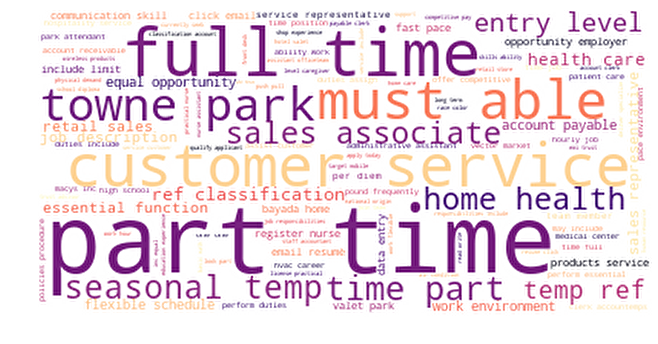

In [68]:
plt.figure(figsize=[11,11])
plt.imshow(wordcloud, interpolation="sinc")
plt.axis("off")
plt.show()

In [74]:
!wget https://microventures.com/wp-content/uploads/team-1697987_640.png >img1

--2019-07-07 02:47:15--  https://microventures.com/wp-content/uploads/team-1697987_640.png
Resolving microventures.com (microventures.com)... 146.148.53.236
Connecting to microventures.com (microventures.com)|146.148.53.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31568 (31K) [image/png]
Saving to: ‘team-1697987_640.png’

team-1697987_640.pn 100%[===================>]  30.83K  --.-KB/s    in 0s      

2019-07-07 02:47:15 (108 MB/s) - ‘team-1697987_640.png’ saved [31568/31568]



In [0]:
!mv team-1697987_640.png wf.png

In [0]:
img = Image.open("wf.png").convert('RGBA')
x = np.array(img)
r, g, b, a = np.rollaxis(x, axis = -1)
r[a == 0] = 255
g[a == 0] = 255
b[a == 0] = 255
x = np.dstack([r, g, b, a])
img = Image.fromarray(x, 'RGBA')


In [0]:
thresh = 200
fn = lambda x : 255 if x <= thresh else 0
wf_mask = img.convert('L').point(fn, mode='1')
wf_mask = np.array(wf_mask)


In [0]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [0]:
transformed_wf_mask = np.ndarray((wf_mask.shape[0],wf_mask.shape[1]), np.int32)

for i in range(len(wf_mask)):
    transformed_wf_mask[i] = list(map(transform_format, wf_mask[i]))

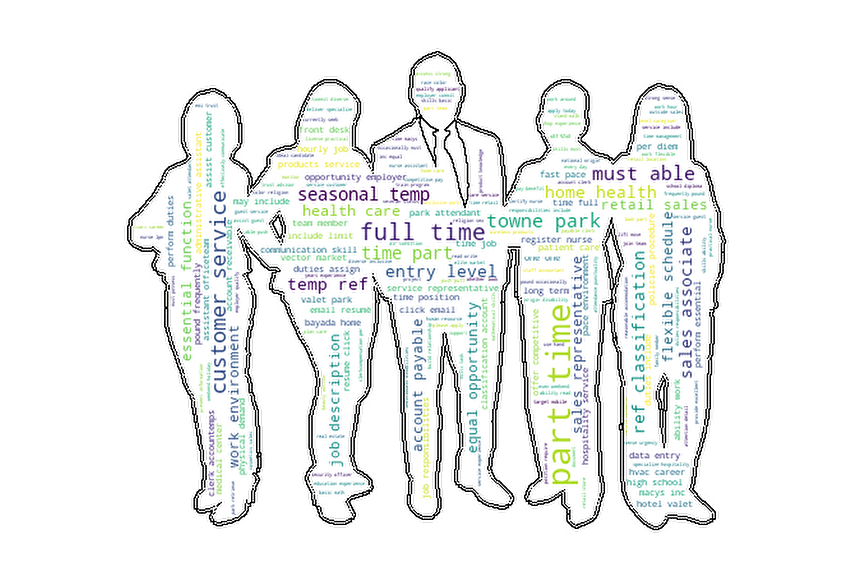

In [80]:
wc = WordCloud(background_color="white", mask=transformed_wf_mask,
               stopwords=stopwords, contour_width=.1, contour_color='black')

# Generate a wordcloud
wc.generate(bunch_text)

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation="sinc")
plt.axis("off")
plt.show()